In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Paths to extracted features
AUDIO_FEATURES_DIR = "C:\\Users\\Owner\\Documents\\Project\\Features\\Audio_features_temporal"
VIDEO_FEATURES_DIR = "D:\\AuxFormer\\data\\Videos"
METADATA_FILE = "C:\\Users\\Owner\\Documents\\Project\\processed_data\\processed_metadata.csv"

# Load metadata
metadata_df = pd.read_csv(METADATA_FILE)
selected_files = sorted(metadata_df["filename"].tolist())  # Ensure order consistency

# Filter valid audio files
valid_audio_files = {f.replace(".npy", "") for f in os.listdir(AUDIO_FEATURES_DIR) if f.endswith(".npy")}

# Video structure has changed: now each video is a folder
valid_video_folders = {folder for folder in os.listdir(VIDEO_FEATURES_DIR)
                       if os.path.isdir(os.path.join(VIDEO_FEATURES_DIR, folder))}

# Match only those that exist in both modalities
common_files = sorted(list(valid_audio_files & valid_video_folders))

# Filter metadata to matched files only
metadata_df = metadata_df[metadata_df["filename"].isin(common_files)]

# Extract emotion labels
metadata_df["label"] = metadata_df["filename"].apply(lambda x: x.split("_")[2])

# Map to numeric labels
EMOTION_MAP = {"ANG": 0, "DIS": 1, "FEA": 2, "HAP": 3, "NEU": 4, "SAD": 5}
metadata_df["label"] = metadata_df["label"].map(EMOTION_MAP)

print(f"Total Matched Samples: {len(common_files)}")


Total Matched Samples: 7435


In [2]:
# Train-Test-Validation Split
train_files, test_files = train_test_split(common_files, test_size=0.15, stratify=metadata_df["label"], random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.15, stratify=metadata_df[metadata_df["filename"].isin(test_files)]["label"], random_state=42)

# Convert to sets for easy lookup
train_set, val_set, test_set = set(train_files), set(val_files), set(test_files)

print(f"Train Samples: {len(train_set)}, Validation Samples: {len(val_set)}, Test Samples: {len(test_set)}")


Train Samples: 6319, Validation Samples: 948, Test Samples: 168


In [3]:
import torch
import numpy as np

class MultiModalDataset(Dataset):
    def __init__(self, file_list, audio_dir, video_dir, labels, max_video_length=100):
        """
        Args:
        - file_list: List of filenames (without extension)
        - audio_dir: Path to saved audio feature .npy files
        - video_dir: Path to saved video feature .npy files (each video folder contains multiple .npy files per timestamp)
        - labels: Dictionary mapping filenames to emotion labels
        - max_video_length: Maximum allowed length for video sequences
        """
        self.file_list = file_list
        self.audio_dir = audio_dir
        self.video_dir = video_dir
        self.labels = labels
        self.max_video_length = max_video_length  # max length for video sequences

    def __len__(self):
        return len(self.file_list)

    def load_video_features(self, video_id):
        """
        Load video features (timestamped .npy files) from a video folder.
        Each .npy file contains a (50,) feature vector.
        Pads or truncates sequences to max_video_length.
        """
        segment_dir = os.path.join(self.video_dir, video_id)
        segment_files = sorted([
            f for f in os.listdir(segment_dir) if f.endswith(".npy") and f.startswith("exp_")
        ])

        segment_features = []
        for file in segment_files:
            path = os.path.join(segment_dir, file)
            arr = np.load(path)  # shape: (50,)
            segment_features.append(arr)

        # Pad or truncate the sequence to max_video_length
        num_segments = len(segment_features)
        if num_segments < self.max_video_length:
            padding = np.zeros((self.max_video_length - num_segments, 50))  # pad with zero vectors
            segment_features = np.vstack([segment_features, padding])
        else:
            segment_features = segment_features[:self.max_video_length]  # truncate to max_video_length

        return torch.tensor(segment_features, dtype=torch.float32)  # shape: (max_video_length, 50)

    def __getitem__(self, idx):
        file_id = self.file_list[idx]

        # ** Load Audio Features (Shape: [feature_dim, T]) **
        audio_features = np.load(os.path.join(self.audio_dir, file_id + ".npy"))
        audio_features = torch.tensor(audio_features, dtype=torch.float32)  # (161, 94)

        # ** Load Video Features (Sequence of 50-dimensional feature vectors) **
        video_features = self.load_video_features(file_id)  # Shape: (max_video_length, 50)
         #print(f"Audio Features Shape: {audio_features.shape}")
        #print(f"Video Features Shape: {video_features.shape}")

        # ** Load Label **
        label = torch.tensor(self.labels[file_id], dtype=torch.long)

        return audio_features, video_features, label


In [4]:
# Create label mapping
file_to_label = dict(zip(metadata_df["filename"], metadata_df["label"]))

# Create Dataset instances (using updated MultiModalDataset)
train_dataset = MultiModalDataset(
    list(train_set), AUDIO_FEATURES_DIR, VIDEO_FEATURES_DIR, file_to_label
)
val_dataset = MultiModalDataset(
    list(val_set), AUDIO_FEATURES_DIR, VIDEO_FEATURES_DIR, file_to_label
)
test_dataset = MultiModalDataset(
    list(test_set), AUDIO_FEATURES_DIR, VIDEO_FEATURES_DIR, file_to_label
)

# Define DataLoader parameters
BATCH_SIZE = 10

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f" Data Loaders Created - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


 Data Loaders Created - Train: 632, Val: 95, Test: 17


In [5]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Fetch a batch
batch = next(iter(train_loader))
audio_batch, video_batch, label_batch = batch

print(f"Audio Batch Shape: {audio_batch.shape}")  # Expected: (batch, 161, 94)
print(f"Video Batch Shape: {video_batch.shape}")  # Expected: (batch, 32, 768)

print(f"Label Batch Shape: {label_batch.shape}")  # Expected: (batch,)


Audio Batch Shape: torch.Size([10, 161, 94])
Video Batch Shape: torch.Size([10, 100, 50])
Label Batch Shape: torch.Size([10])


# GRU MODEL

In [6]:
import torch
import torch.nn as nn

class AudioGRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, embedding_dim):
        super(AudioGRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.21),
            nn.Linear(256, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Ensure proper shape: (batch, time_steps, feature_dim)
        _, h_n = self.gru(x)
        out = self.fc(h_n[-1])  # Use last hidden state
        return out  # (batch, embedding_dim)



In [7]:
import torch
import torch.nn as nn

class VideoCNNGRUModel(nn.Module):
    def __init__(self, vit_feature_dim, gru_hidden_dim, num_layers, embedding_dim):
        super(VideoCNNGRUModel, self).__init__()
        self.fc_vit = nn.Sequential(
            nn.Linear(vit_feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        self.gru = nn.GRU(256, gru_hidden_dim, num_layers, batch_first=True)
        self.layer_norm_gru = nn.LayerNorm(gru_hidden_dim)
        self.fc = nn.Linear(gru_hidden_dim, embedding_dim)

    def forward(self, vit_features):
        # Process ViT features through fully connected layers
        batch_size, seq_len, feature_dim = vit_features.shape
        vit_features = vit_features.view(batch_size * seq_len, feature_dim)
        vit_features = self.fc_vit(vit_features)
        vit_features = vit_features.view(batch_size, seq_len, -1)

        # GRU to capture temporal dependencies
        _, h_n = self.gru(vit_features)
        out = self.fc(h_n[-1])  # Use last hidden state

        return out  # (batch, embedding_dim)


In [8]:
import torch
import torch.nn as nn

class CrossAttentionBidirectional(nn.Module):
    def __init__(self, embed_dim, dropout_p=0.1):
        super(CrossAttentionBidirectional, self).__init__()
        self.attn_audio_to_video = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.attn_video_to_audio = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.norm_audio = nn.LayerNorm(embed_dim)
        self.norm_video = nn.LayerNorm(embed_dim)

    def forward(self, audio_embed, video_embed):
        # Add sequence dimension (seq_len=1)
        audio_embed = audio_embed.unsqueeze(1)  # (batch, 1, embed_dim)
        video_embed = video_embed.unsqueeze(1)  # (batch, 1, embed_dim)

        # Audio attends to Video
        audio_attn, _ = self.attn_audio_to_video(audio_embed, video_embed, video_embed)
        audio_attn = self.dropout(audio_attn)  # Dropout after attention
        audio_out = self.norm_audio(audio_embed + audio_attn)  # Add & Norm

        # Video attends to Audio
        video_attn, _ = self.attn_video_to_audio(video_embed, audio_embed, audio_embed)
        video_attn = self.dropout(video_attn)  # Dropout after attention
        video_out = self.norm_video(video_embed + video_attn)  # Add & Norm

        # Remove sequence dimension
        return audio_out.squeeze(1), video_out.squeeze(1)


In [9]:
import torch
import torch.nn as nn

class FusionModel(nn.Module):
    def __init__(self, audio_model, video_model, embedding_dim, num_classes):
        super(FusionModel, self).__init__()
        self.audio_model = audio_model
        self.video_model = video_model

        # 3 layers of bidirectional cross-attention
        self.cross_attn_layers = nn.ModuleList([
            CrossAttentionBidirectional(embedding_dim) for _ in range(3)
        ])

        self.layer_norm_fusion = nn.LayerNorm(embedding_dim * 4)
        self.fc_fusion = nn.Linear(embedding_dim * 4, num_classes)

    def forward(self, audio_input, video_input):
        # Get initial embeddings from sub-models
        audio_embed = self.audio_model(audio_input)  # (batch, embed_dim)
        video_embed = self.video_model(video_input)  # (batch, embed_dim)
        audio_embed_raw = self.audio_model(audio_input)  # (batch, embed_dim)
        video_embed_raw = self.video_model(video_input)  # (batch, embed_dim)

        # Apply stacked cross-attention layers
        for layer in self.cross_attn_layers:
            audio_embed, video_embed = layer(audio_embed, video_embed)

        # Concatenate and fuse for classification
        fused = torch.cat((audio_embed_raw,audio_embed, video_embed,video_embed_raw), dim=1)  # (batch, embed_dim * 2)
        fused = self.layer_norm_fusion(fused)
        logits = self.fc_fusion(fused)  # Classification output

        # Return both classification and embeddings for contrastive learning
        return logits, audio_embed, video_embed


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Initialize models
audio_model = AudioGRUModel(input_dim=161, hidden_dim=256, num_layers=2, embedding_dim=128)
video_model = VideoCNNGRUModel(vit_feature_dim=50, gru_hidden_dim=256, num_layers=2, embedding_dim=128)
fusion_model = FusionModel(audio_model, video_model, embedding_dim=128, num_classes=6)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fusion_model.to(device)

# Loss, optimizer, scheduler
classification_loss_fn = nn.CrossEntropyLoss()
contrastive_loss_fn = nn.CosineEmbeddingLoss(margin=0.3)  # can be changed as per preferred margin

optimizer = optim.AdamW(fusion_model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training config
num_epochs = 80
best_val_acc = 0.0

print(f"Training on: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"Train Batches: {len(train_loader)}, Val Batches: {len(val_loader)}, Test Batches: {len(test_loader)}")

for epoch in range(num_epochs):
    fusion_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for audio_inputs, video_inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        audio_inputs, video_inputs, labels = audio_inputs.to(device), video_inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, audio_embed, video_embed = fusion_model(audio_inputs, video_inputs)

        # ── Classification Loss ──
        classification_loss = classification_loss_fn(logits, labels)

        # ── Contrastive Loss ──
        # +1 for matching audio-video pairs
        similarity_labels = torch.ones(audio_embed.size(0)).to(device)
        contrastive_loss = contrastive_loss_fn(audio_embed, video_embed, similarity_labels)

        # ── Total Loss ──
        loss = classification_loss + contrastive_loss  # You can weight them if needed

        loss.backward()
        torch.nn.utils.clip_grad_norm_(fusion_model.parameters(), max_norm=5)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)


    # ─── Validation ─────────────────────────────────────
    fusion_model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        val_progress = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False)
        for audio_inputs, video_inputs, labels in val_progress:
            audio_inputs, video_inputs, labels = \
                audio_inputs.to(device), video_inputs.to(device), labels.to(device)

            outputs,_,_ = fusion_model(audio_inputs, video_inputs)
            loss = classification_loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    # ─── Checkpointing ─────────────────────────────────
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': fusion_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc
        }, "C:\\Users\\Owner\\Documents\\Best_CrossAttention_FusionModel.pth")
        print("✅ Model Saved (New Best)")

    # ─── Logging ────────────────────────────────────────
    print(f" Epoch {epoch+1} Summary:")
    print(f"   🔹 Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   🔹 Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"   🔹 Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    torch.cuda.empty_cache()

print("Training Complete!")

# ─── Test Phase ────────────────────────────────────────
fusion_model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    test_progress = tqdm(test_loader, desc="Testing", leave=False)
    for audio_inputs, video_inputs, labels in test_progress:
        audio_inputs, video_inputs, labels = \
            audio_inputs.to(device), video_inputs.to(device), labels.to(device)

        outputs = fusion_model(audio_inputs, video_inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)

print("\nFinal Test Results:")
print(f" Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")


Training on: GPU
Train Batches: 632, Val Batches: 95, Test Batches: 17


Epoch 1:   0%|▎                                                                      | 3/632 [00:25<1:28:58,  8.49s/it]C:\Users\Owner\AppData\Local\Temp\ipykernel_20184\1074825672.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  return torch.tensor(segment_features, dtype=torch.float32)  # shape: (max_video_length, 50)
                                                                                                                       

✅ Model Saved (New Best)
 Epoch 1 Summary:
   🔹 Train Loss: 1.2550 | Train Acc: 52.71%
   🔹 Val Loss: 0.9553 | Val Acc: 61.81%
   🔹 Current LR: 0.000500


✅ Model Saved (New Best)
 Epoch 2 Summary:
   🔹 Train Loss: 0.8559 | Train Acc: 68.51%
   🔹 Val Loss: 0.7965 | Val Acc: 71.41%
   🔹 Current LR: 0.000500


✅ Model Saved (New Best)
 Epoch 3 Summary:
   🔹 Train Loss: 0.7400 | Train Acc: 73.41%
   🔹 Val Loss: 0.6775 | Val Acc: 76.16%
   🔹 Current LR: 0.000500


 Epoch 4 Summary:
   🔹 Train Loss: 0.6520 | Train Acc: 75.99%
   🔹 Val Loss: 0.7451 | Val Acc: 73.52%
   🔹 Current LR: 0.000500


 Epoch 5 Summary:
   🔹 Train Loss: 0.6044 | Train Acc: 78.37%
   🔹 Val Loss: 0.6716 | Val Acc: 75.53%
   🔹 Current LR: 0.000500


✅ Model Saved (New Best)
 Epoch 6 Summary:
   🔹 Train Loss: 0.5677 | Train Acc: 78.92%
   🔹 Val Loss: 0.5976 | Val Acc: 77.74%
   🔹 Current LR: 0.000500


 Epoch 7 Summary:
   🔹 Train Loss: 0.5018 | Train Acc: 81.61%
   🔹 Val Loss: 0.6599 | Val Acc: 77.32%
   🔹 Current LR: 0.000500


✅ Model Saved (New Best)
 Epoch 8 Summary:
   🔹 Train Loss: 0.4830 | Train Acc: 82.26%
   🔹 Val Loss: 0.6537 | Val Acc: 78.27%
   🔹 Current LR: 0.000500


Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.
 Epoch 9 Summary:
   🔹 Train Loss: 0.4234 | Train Acc: 84.25%
   🔹 Val Loss: 0.6899 | Val Acc: 77.11%
   🔹 Current LR: 0.000250


✅ Model Saved (New Best)
 Epoch 10 Summary:
   🔹 Train Loss: 0.2933 | Train Acc: 89.75%
   🔹 Val Loss: 0.6297 | Val Acc: 81.43%
   🔹 Current LR: 0.000250


 Epoch 11 Summary:
   🔹 Train Loss: 0.2254 | Train Acc: 91.98%
   🔹 Val Loss: 0.7493 | Val Acc: 78.90%
   🔹 Current LR: 0.000250


Epoch 00012: reducing learning rate of group 0 to 1.2500e-04.
 Epoch 12 Summary:
   🔹 Train Loss: 0.1749 | Train Acc: 94.10%
   🔹 Val Loss: 0.7278 | Val Acc: 80.80%
   🔹 Current LR: 0.000125


 Epoch 13 Summary:
   🔹 Train Loss: 0.1081 | Train Acc: 96.33%
   🔹 Val Loss: 0.7587 | Val Acc: 80.80%
   🔹 Current LR: 0.000125


 Epoch 14 Summary:
   🔹 Train Loss: 0.0722 | Train Acc: 97.71%
   🔹 Val Loss: 0.7934 | Val Acc: 79.54%
   🔹 Current LR: 0.000125


Epoch 00015: reducing learning rate of group 0 to 6.2500e-05.
 Epoch 15 Summary:
   🔹 Train Loss: 0.0598 | Train Acc: 98.26%
   🔹 Val Loss: 0.7833 | Val Acc: 80.27%
   🔹 Current LR: 0.000063


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(dataloader, dataset_name="Validation"):
    all_preds = []
    all_labels = []
    
    fusion_model.eval()
    with torch.no_grad():
        for audio_inputs, video_inputs, labels in dataloader:
            audio_inputs = audio_inputs.to(device)
            video_inputs = video_inputs.to(device)
            labels = labels.to(device)

            logits, _, _ = fusion_model(audio_inputs, video_inputs)
            _, predicted = torch.max(logits, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ─── Metrics ───────────────────────────────────────
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='micro', zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    print(f"\n Classification Report ({dataset_name} Set):")
    print(report)
    print("🔹 Micro Avg  - Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}".format(
        precision_micro, recall_micro, f1_micro))
    print("🔹 Macro Avg  - Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}".format(
        precision_macro, recall_macro, f1_macro))

    # ─── Confusion Matrix Plot ─────────────────────────
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({dataset_name} Set)")
    plt.tight_layout()
    plt.show()

# Evaluate on validation set
evaluate_model(val_loader, "Validation")

# Evaluate on test set
evaluate_model(test_loader, "Test")


In [11]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_fscore_support
)
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

def compute_cosine_similarity(audio_embeddings, video_embeddings):
    audio_norm = F.normalize(audio_embeddings, p=2, dim=1)
    video_norm = F.normalize(video_embeddings, p=2, dim=1)
    cosine_sim = torch.sum(audio_norm * video_norm, dim=1)
    return cosine_sim.mean().item()

def compute_average_correlation(audio_embeds, video_embeds, method="pearson"):
    audio_np = audio_embeds.numpy()
    video_np = video_embeds.numpy()
    correlations = []

    for i in range(audio_np.shape[1]):
        try:
            if method == "pearson":
                corr, _ = pearsonr(audio_np[:, i], video_np[:, i])
            else:
                corr, _ = spearmanr(audio_np[:, i], video_np[:, i])
            correlations.append(corr)
        except Exception:
            continue  # handle nan or constant vectors

    return np.nanmean(correlations)

def evaluate_model(dataloader, dataset_name="Validation"):
    all_preds, all_labels = [], []
    all_audio_embeds, all_video_embeds = [], []

    fusion_model.eval()
    with torch.no_grad():
        for audio_inputs, video_inputs, labels in dataloader:
            audio_inputs = audio_inputs.to(device)
            video_inputs = video_inputs.to(device)
            labels = labels.to(device)

            logits, audio_embed, video_embed = fusion_model(audio_inputs, video_inputs)
            _, predicted = torch.max(logits, dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            all_audio_embeds.append(audio_embed.cpu())
            all_video_embeds.append(video_embed.cpu())

    # ─── Stack Embeddings ─────────────────────────────
    audio_embeds = torch.cat(all_audio_embeds, dim=0)
    video_embeds = torch.cat(all_video_embeds, dim=0)

    # ─── Metrics ─────────────────────────────────────
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='micro', zero_division=0)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0)

    # ─── Alignment Scores ────────────────────────────
    cosine_sim = compute_cosine_similarity(audio_embeds, video_embeds)
    pearson_corr = compute_average_correlation(audio_embeds, video_embeds, method="pearson")
    spearman_corr = compute_average_correlation(audio_embeds, video_embeds, method="spearman")

    # ─── Output ──────────────────────────────────────
    print(f"\n Classification Report ({dataset_name} Set):")
    print(report)
    print("🔹 Micro Avg  - Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}".format(
        precision_micro, recall_micro, f1_micro))
    print("🔹 Macro Avg  - Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}".format(
        precision_macro, recall_macro, f1_macro))
    
    print(f"\n Alignment Between Modalities ({dataset_name} Set):")
    print(f"    • Avg Cosine Similarity: {cosine_sim:.4f}")
    print(f"    • Avg Pearson Correlation: {pearson_corr:.4f}")
    print(f"    • Avg Spearman Correlation: {spearman_corr:.4f}")

    # ─── Confusion Matrix Plot ───────────────────────
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({dataset_name} Set)")
    plt.tight_layout()
    plt.show()



 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.8503    0.8503    0.8503       167
           1     0.8412    0.8882    0.8640       161
           2     0.7465    0.6310    0.6839       168
           3     0.9620    0.9560    0.9590       159
           4     0.8636    0.7862    0.8231       145
           5     0.6034    0.7297    0.6606       148

    accuracy                         0.8070       948
   macro avg     0.8112    0.8069    0.8068       948
weighted avg     0.8126    0.8070    0.8076       948

🔹 Micro Avg  - Precision: 0.8070 | Recall: 0.8070 | F1 Score: 0.8070
🔹 Macro Avg  - Precision: 0.8112 | Recall: 0.8069 | F1 Score: 0.8068

 Alignment Between Modalities (Validation Set):
    • Avg Cosine Similarity: 1.0000
    • Avg Pearson Correlation: 0.9748
    • Avg Spearman Correlation: 0.9712


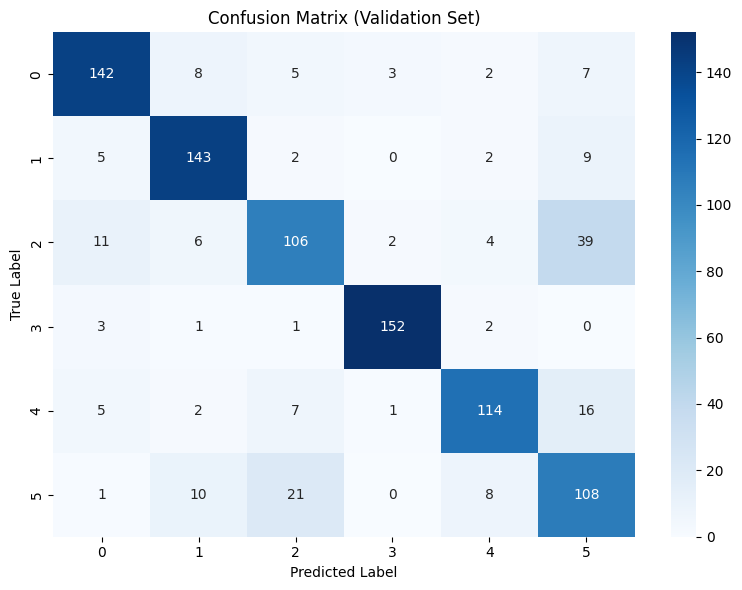


 Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.8696    0.8333    0.8511        24
           1     0.8800    0.7333    0.8000        30
           2     0.7500    0.8182    0.7826        22
           3     0.9697    1.0000    0.9846        32
           4     0.8000    0.6667    0.7273        18
           5     0.7500    0.8571    0.8000        42

    accuracy                         0.8333       168
   macro avg     0.8365    0.8181    0.8243       168
weighted avg     0.8375    0.8333    0.8324       168

🔹 Micro Avg  - Precision: 0.8333 | Recall: 0.8333 | F1 Score: 0.8333
🔹 Macro Avg  - Precision: 0.8365 | Recall: 0.8181 | F1 Score: 0.8243

 Alignment Between Modalities (Test Set):
    • Avg Cosine Similarity: 1.0000
    • Avg Pearson Correlation: 0.9757
    • Avg Spearman Correlation: 0.9697


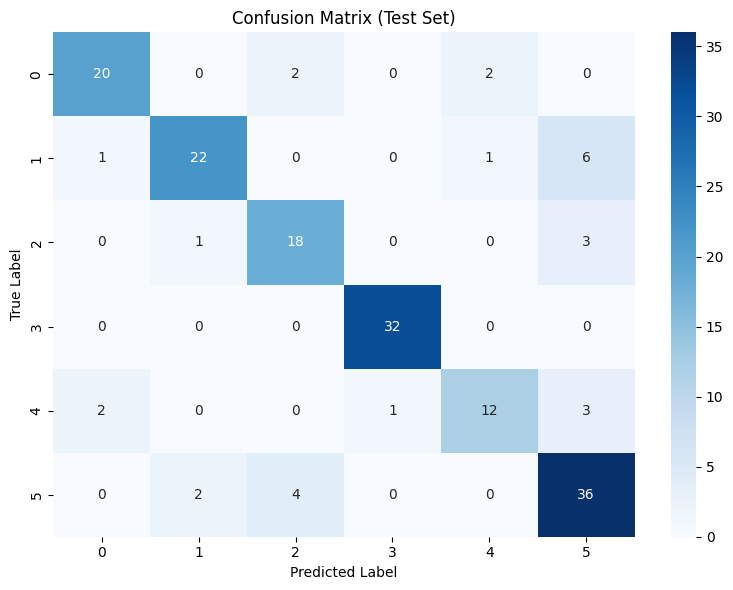

In [12]:
evaluate_model(val_loader, "Validation")
evaluate_model(test_loader, "Test")


In [13]:
def compute_alignment_metrics(audio_embed, video_embed, label=""):
    audio_norm = F.normalize(audio_embed, p=2, dim=1)
    video_norm = F.normalize(video_embed, p=2, dim=1)
    cosine_sim = torch.sum(audio_norm * video_norm, dim=1).mean().item()

    def avg_corr(a, v, method):
        a_np, v_np = a.numpy(), v.numpy()
        corrs = []
        for i in range(a_np.shape[1]):
            try:
                if method == "pearson":
                    corr, _ = pearsonr(a_np[:, i], v_np[:, i])
                else:
                    corr, _ = spearmanr(a_np[:, i], v_np[:, i])
                corrs.append(corr)
            except:
                continue
        return np.nanmean(corrs)

    pearson = avg_corr(audio_embed.cpu(), video_embed.cpu(), method="pearson")
    spearman = avg_corr(audio_embed.cpu(), video_embed.cpu(), method="spearman")

    print(f"\n {label} Alignment Scores:")
    print(f"   • Cosine Similarity:       {cosine_sim:.4f}")
    print(f"   • Pearson Correlation:     {pearson:.4f}")
    print(f"   • Spearman Correlation:    {spearman:.4f}")

def evaluate_alignment_on_test(dataloader):
    fusion_model.eval()
    all_audio_raw, all_video_raw = [], []
    all_audio_aligned, all_video_aligned = [], []

    with torch.no_grad():
        for audio_inputs, video_inputs, _ in dataloader:
            audio_inputs = audio_inputs.to(device)
            video_inputs = video_inputs.to(device)

            # Unaligned embeddings from sub-models
            audio_embed_raw = fusion_model.audio_model(audio_inputs)
            video_embed_raw = fusion_model.video_model(video_inputs)

            all_audio_raw.append(audio_embed_raw.cpu())
            all_video_raw.append(video_embed_raw.cpu())

            # Pass through cross-attention layers (alignment)
            audio_embed = audio_embed_raw
            video_embed = video_embed_raw
            for layer in fusion_model.cross_attn_layers:
                audio_embed, video_embed = layer(audio_embed, video_embed)

            all_audio_aligned.append(audio_embed.cpu())
            all_video_aligned.append(video_embed.cpu())

    # Concatenate all batches
    audio_raw = torch.cat(all_audio_raw, dim=0)
    video_raw = torch.cat(all_video_raw, dim=0)
    audio_aligned = torch.cat(all_audio_aligned, dim=0)
    video_aligned = torch.cat(all_video_aligned, dim=0)

    # Compute alignment scores
    compute_alignment_metrics(audio_raw, video_raw, label="Before Cross-Attention")
    compute_alignment_metrics(audio_aligned, video_aligned, label="After Cross-Attention")

# Run it
evaluate_alignment_on_test(test_loader)



 Before Cross-Attention Alignment Scores:
   • Cosine Similarity:       0.0798
   • Pearson Correlation:     -0.0096
   • Spearman Correlation:    -0.0122

 After Cross-Attention Alignment Scores:
   • Cosine Similarity:       1.0000
   • Pearson Correlation:     0.9757
   • Spearman Correlation:    0.9697
